In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sns
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn. linear_model import Ridge, RidgeCV
from sklearn. compose import ColumnTransformer
import time

WITH_VELOCITIES = False

In [212]:
data = pd.read_csv("../data/X_train.csv")
data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [213]:
data.columns

Index(['t', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3', 'Id'],
      dtype='object')

In [214]:
idx = np.hstack((0,data[data.t == 10].index.values +1))
idx. shape, data. t.min(), data. t.max()

((4054,), np.float64(0.0), np.float64(10.0))

1364


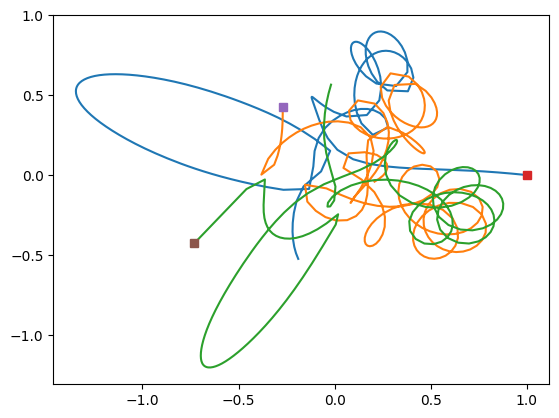

In [215]:
k = np.random. randint(idx. shape [0])
print(k)
pltidx = range(idx[k],257+idx[k])
pltsquare = idx [k]
plt.plot(data.x_1[pltidx],data.y_1[pltidx])
plt.plot(data.x_2[pltidx],data.y_2[pltidx])
plt.plot(data.x_3[pltidx],data.y_3[pltidx])

plt.plot(data.x_1[pltsquare],data.y_1[pltsquare],'s')
plt.plot(data.x_2[pltsquare],data.y_2[pltsquare], 's' )
plt.plot(data.x_3[pltsquare],data.y_3[pltsquare],'s')

Remove all the found data anomalies

#1 - Removed the line with all os

In [216]:
data_without_anomalies = data.loc[~((data.x_1 == 0) & (data.y_1 == 0) & (data.v_x_1 == 0) & (data.v_y_1 == 0) &
                  (data.x_2 == 0) & (data.y_2 == 0) & (data.v_x_2 == 0) & (data.v_y_2 == 0) &
                  (data.x_3 == 0) & (data.y_3 == 0) & (data.v_x_3 == 0) & (data.v_y_3 == 0))]
data_without_anomalies = data_without_anomalies.reset_index(drop=True)

In [217]:
def split_by_initial_positions(data, number_of_trajectories = 4998, test_size=0.1, val_size=0.1):

    starts = data.index[np.equal(data["t"], 0.0)].to_list()
    starts.append(len(data))

    print("Number of trajectories:", len(starts)-1)

    all_trajectories = []
    for i in range(len(starts)-1):
        all_trajectories.append(data.iloc[starts[i]:starts[i+1], :])

    np.random.shuffle(all_trajectories)

    n_val   = int(number_of_trajectories * val_size)
    n_test  = int(number_of_trajectories * test_size)
    n_train = number_of_trajectories - n_val - n_test

    print("Train/Val/Test sizes (in trajectory amount):", n_train, n_val, n_test)

    print(len(all_trajectories), "trajectories in total")

    train_data = pd.concat(all_trajectories[:n_train], ignore_index=True)
    val_data   = pd.concat(all_trajectories[n_train:n_train+n_val],ignore_index=True)
    test_data  = pd.concat(all_trajectories[n_train+n_val:n_train+n_val+n_test],ignore_index=True)

    return train_data, val_data, test_data

In [218]:
train_data, val_data, test_data = split_by_initial_positions(data_without_anomalies,4998)

Number of trajectories: 4998
Train/Val/Test sizes (in trajectory amount): 4000 499 499
4998 trajectories in total


 Task 1.2 - Learn the Baseline Model

In [219]:
def create_splits(data_for_splts):

    data_with_intial_positions = data_for_splts.copy()

    initial = data.query("t == 0.0")[['Id','x_1','y_1','x_2','y_2','x_3','y_3']].copy()
    initial = initial.rename(columns={
        'x_1': 'x0_1', 'y_1': 'y0_1',
        'x_2': 'x0_2', 'y_2': 'y0_2',
        'x_3': 'x0_3', 'y_3': 'y0_3',
    })

    if WITH_VELOCITIES:
        initial_velocities = data.query("t == 0.0")[['Id','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']].copy()
        initial = initial.merge(initial_velocities, on='Id', how='left')
        initial = initial.rename(columns={
            'v_x_1': 'v_x_0_1', 'v_y_1': 'v_y_0_1',
            'v_x_2': 'v_x_0_2', 'v_y_2': 'v_y_0_2',
            'v_x_3': 'v_x_0_3', 'v_y_3': 'v_y_0_3',
        })

    merged = pd.merge_asof(
        data_with_intial_positions.sort_values('Id'),
        initial.sort_values('Id'),
        on='Id',
        direction='backward',
        allow_exact_matches=True
    )

    if not WITH_VELOCITIES:
        x_data = merged[['t','x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']]
    else:
        x_data = merged[['t','x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3','v_x_0_1', 'v_y_0_1', 'v_x_0_2', 'v_y_0_2', 'v_x_0_3', 'v_y_0_3']]

    y_data = merged[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']]

    return x_data, y_data, merged


In [220]:
def plot_y_yhat(y_test,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']

    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)
    MAX = 500

    if len(y_test) > MAX:
        idx = np.random.choice(len(y_test),MAX, replace=False)
    else:
        idx = np.arange(len(y_test))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_test[idx,i])
        x1 = np.max(y_test[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_test[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig(plot_title+'.pdf')
    plt.show()

MSE: 2.1482178908354967
RMSE: 1.465680009700445


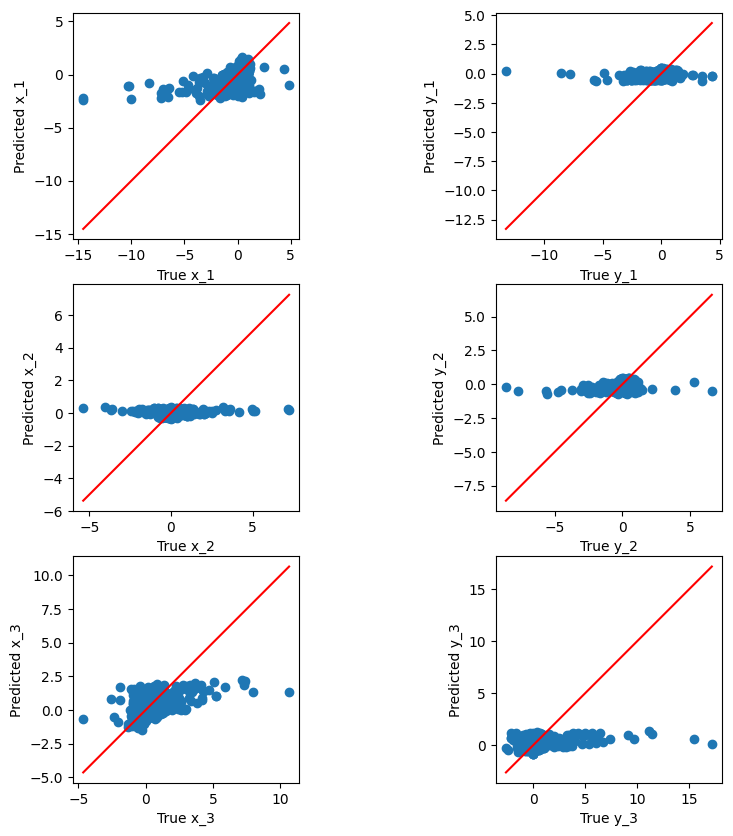

In [221]:
from sklearn.pipeline import make_pipeline

x_train, y_train, updated_train_data = create_splits(train_data)

pipeline = make_pipeline(StandardScaler(),LinearRegression())
pipeline.fit(x_train, y_train)

x_val, y_val,updated_val_data = create_splits(val_data)
y_pred = pipeline.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
print("MSE:",mse)
rmse = np.sqrt(mse)
print("RMSE:",rmse)

x_test, y_test,updated_test_data = create_splits(test_data)
y_pred = pipeline.predict(x_test)

plot_y_yhat(y_test,y_pred)

In [222]:
original_test_data = pd.read_csv("../data/X_test.csv")
test_data = original_test_data.copy()

test_data = test_data.drop(columns=['Id'])

if WITH_VELOCITIES:
    test_data['v_x_0_1'] = 0
    test_data['v_y_0_1'] = 0
    test_data['v_x_0_2'] = 0
    test_data['v_y_0_2'] = 0
    test_data['v_x_0_3'] = 0
    test_data['v_y_0_3'] = 0

y_testData = pipeline.predict(test_data)

submission = pd.DataFrame(y_testData, columns=['x_1','y_1','x_2','y_2','x_3','y_3'])
submission.insert(0, 'Id', range(0, len(submission)))

submission.to_csv('baseline-model.csv',index=False)

Regularization Methods

We tried Ridge(L2), Lasso(L1) and ElasticNet(L1+L2) regularization methods. The best results were obtained with Ridge regression.

Not only were the best results obtained with Ridge regression, but also the training time was significantly lower than with Lasso and ElasticNet allowing us to explore higher polynomial degrees and with more data points (trajectories).

Best Degree

We tried polynomial degrees from 1 to 8. The best results were obtained with degree 4.

In [223]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, MultiTaskElasticNetCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, 
                             regressor=None, degrees=range(4,5), max_features=None):

    if regressor is None:
        regressor = LinearRegression()

    best_rmse = float("inf")
    best_model = None


    for d in degrees:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("regressor", RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='neg_mean_squared_error'))
            #("regressor",MultiTaskLassoCV(alphas=[0.1, 1.0, 10.0], cv=5, max_iter=1000))
            #("regressor", MultiTaskElasticNetCV(alphas=[0.1,1.0,10.0], l1_ratio=[0.5], cv=3, max_iter=10000))
        ])

        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        n_feats = pipe.named_steps["poly"].n_output_features_
        print(f"Degree {d}: RMSE={rmse:.4f}, Features={n_feats}")

        if rmse < best_rmse and (max_features is None or n_feats <= max_features):
            best_rmse = rmse
            best_model = pipe

    return best_model, best_rmse

poly_train_data, poly_val_data, poly_test_data = split_by_initial_positions(data_without_anomalies,4998)
poly_x_train, poly_y_train, updated_poly_train_data = create_splits(poly_train_data)
poly_x_val, poly_y_val,updated_poly_val_data = create_splits(poly_val_data)
best_model, best_rmse = validate_poly_regression(poly_x_train, poly_y_train, poly_x_val, poly_y_val)
print("Best RMSE:", best_rmse)

test_data_poly = pd.read_csv("../data/X_test.csv")

test_data_poly = test_data_poly.drop(columns=['Id'])

if WITH_VELOCITIES:
    test_data['v_x_0_1'] = 0
    test_data['v_y_0_1'] = 0
    test_data['v_x_0_2'] = 0
    test_data['v_y_0_2'] = 0
    test_data['v_x_0_3'] = 0
    test_data['v_y_0_3'] = 0

y_testData_poly = best_model.predict(test_data_poly)

print(y_testData_poly.shape)

submission_poly = pd.DataFrame(y_testData_poly, columns=['x_1','y_1','x_2','y_2','x_3','y_3'])
submission_poly.insert(0, 'Id', range(0, len(submission_poly)))

submission_poly.to_csv('polynomial_submission.csv',index=False)

Number of trajectories: 4998
Train/Val/Test sizes (in trajectory amount): 4000 499 499
4998 trajectories in total
Degree 4: RMSE=1.2436, Features=329
Best RMSE: 1.2435991948170042
(1041621, 6)


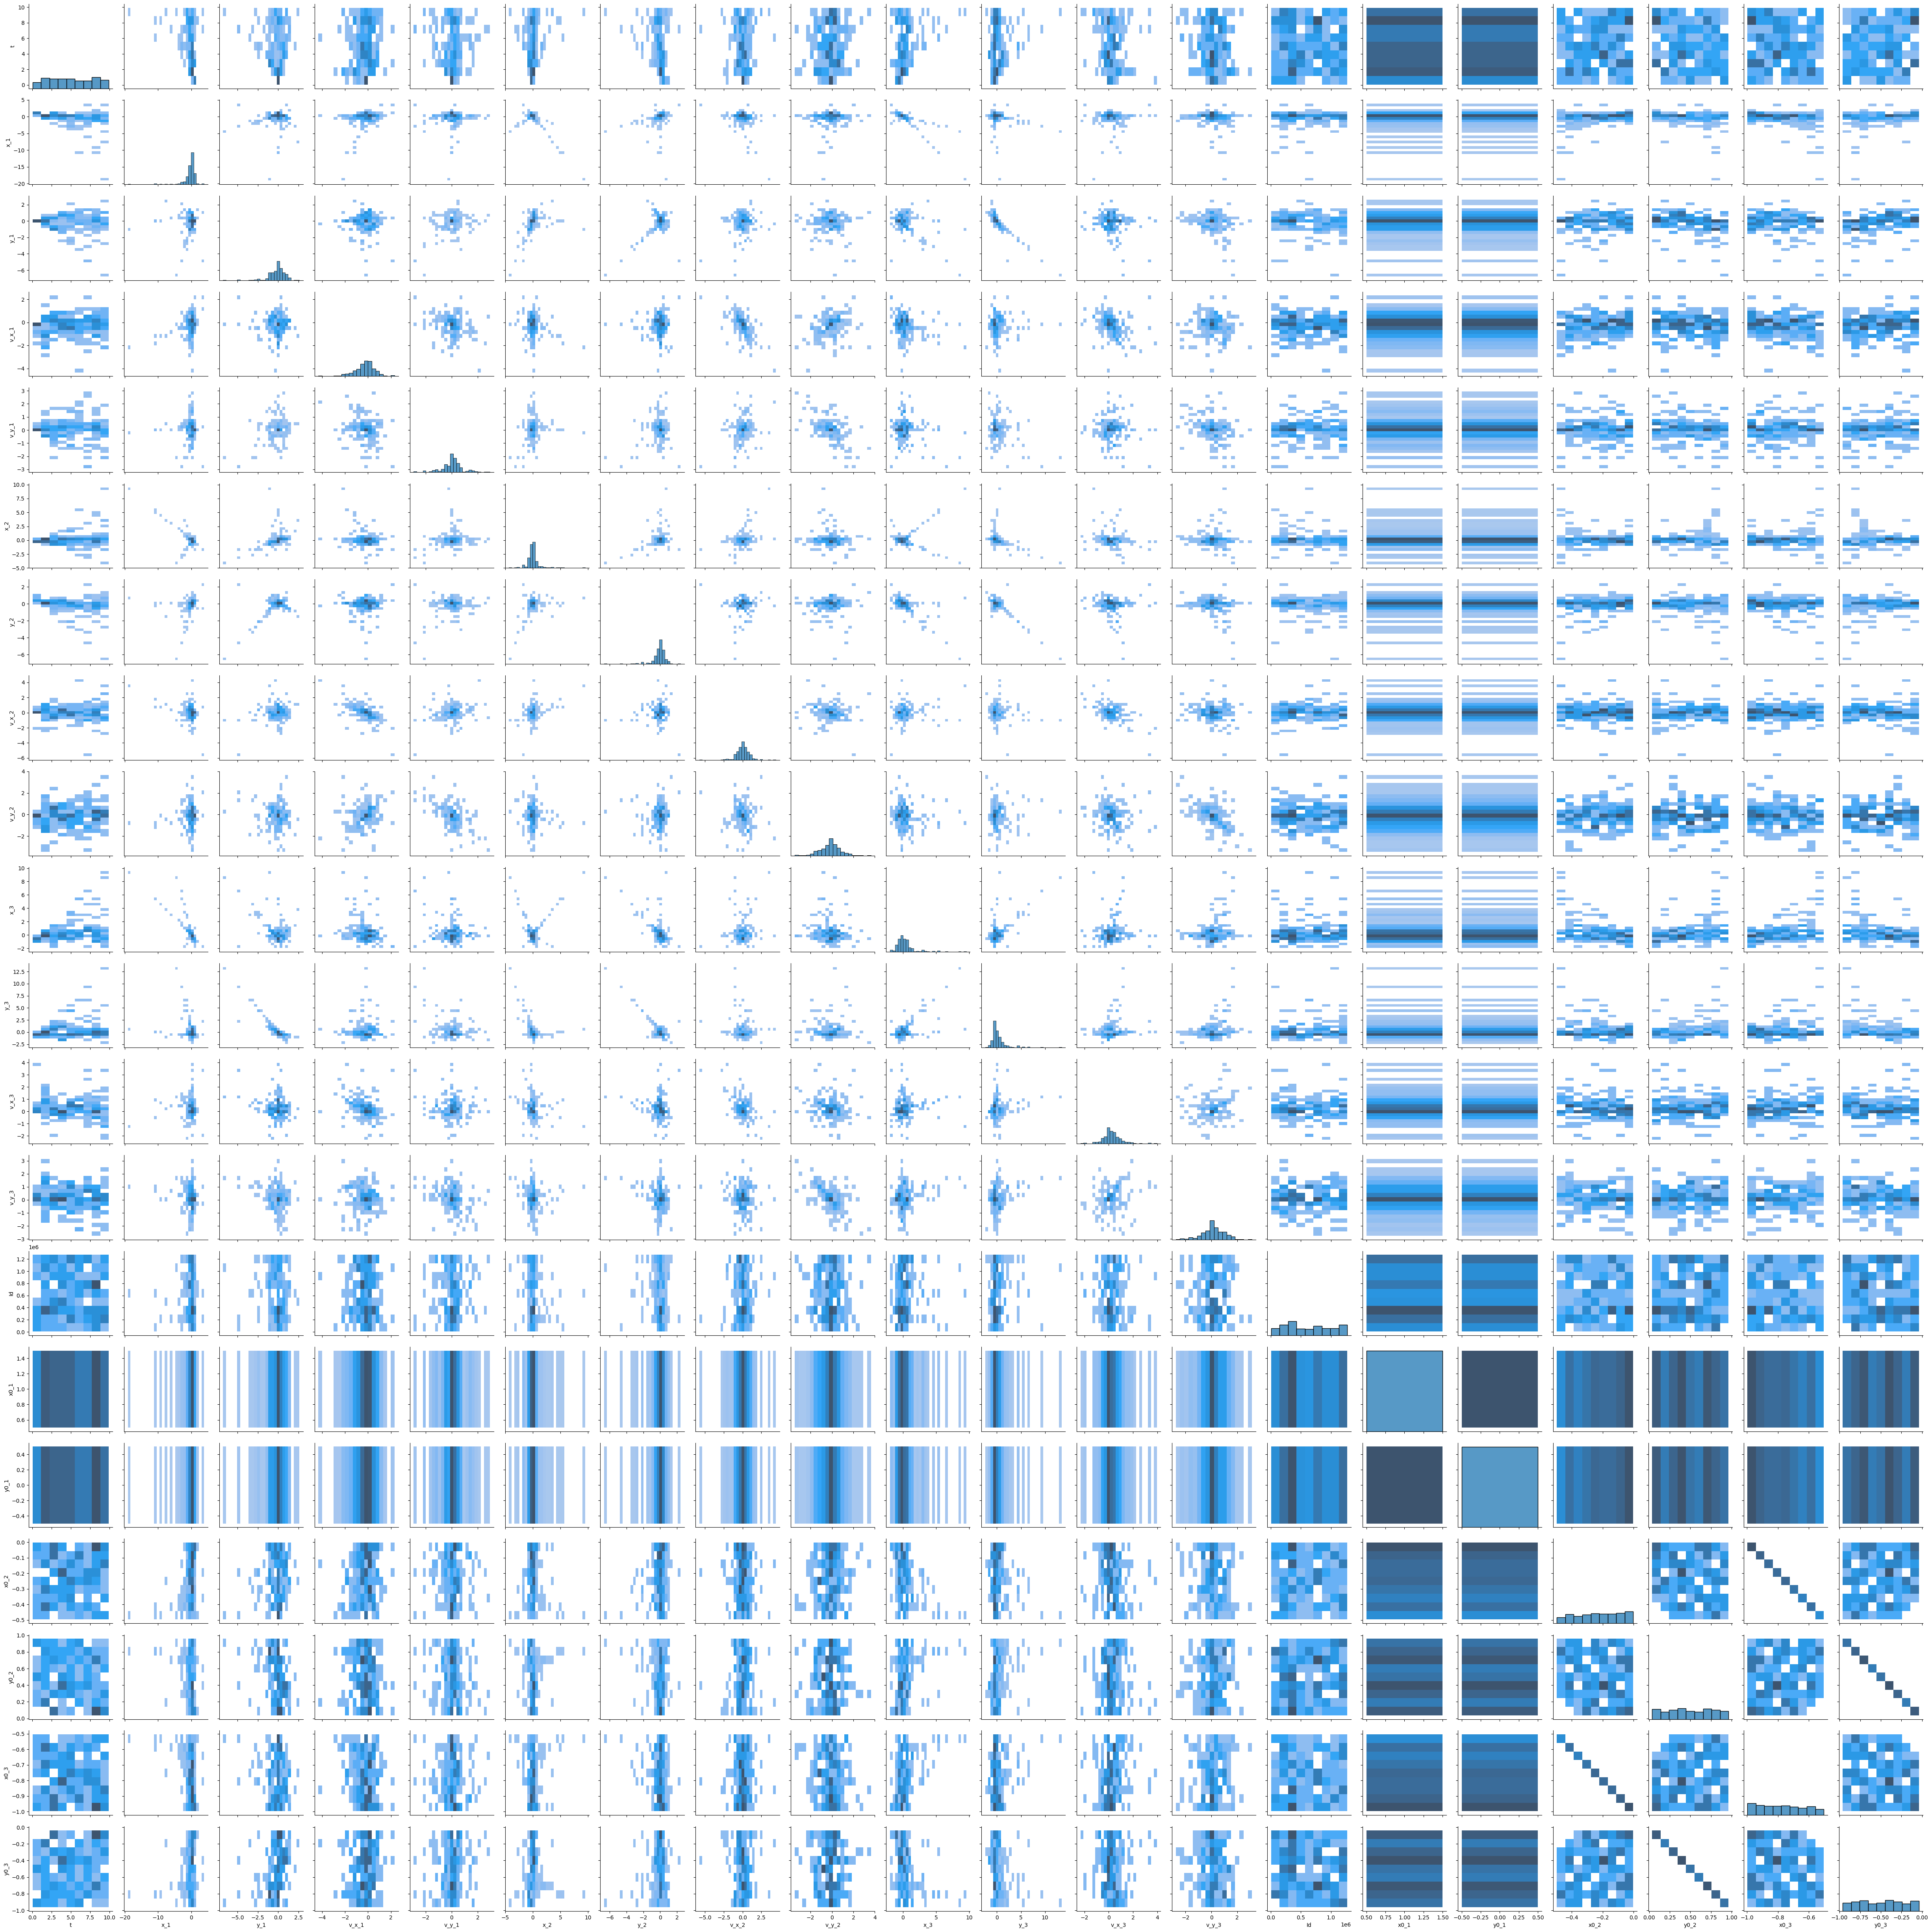

In [224]:
import seaborn as sns

sns.pairplot(updated_train_data.sample(200), kind="hist")

x0_3   x0_2     1.000000
y0_3   y0_2     1.000000
y_3    y_1      0.803714
x_3    x_1      0.781763
y_3    y_2      0.736000
v_y_3  v_y_2    0.627242
v_x_2  v_x_1    0.624261
v_y_2  v_y_1    0.535956
x_2    x_1      0.529706
v_x_3  v_x_2    0.494327
x_2    y_1      0.466248
x_3    y_2      0.443442
y_3    x_3      0.421980
       x_2      0.408089
v_x_3  v_x_1    0.370503
dtype: float64
MSE: 2.1482178908354963
RMSE: 1.465680009700445


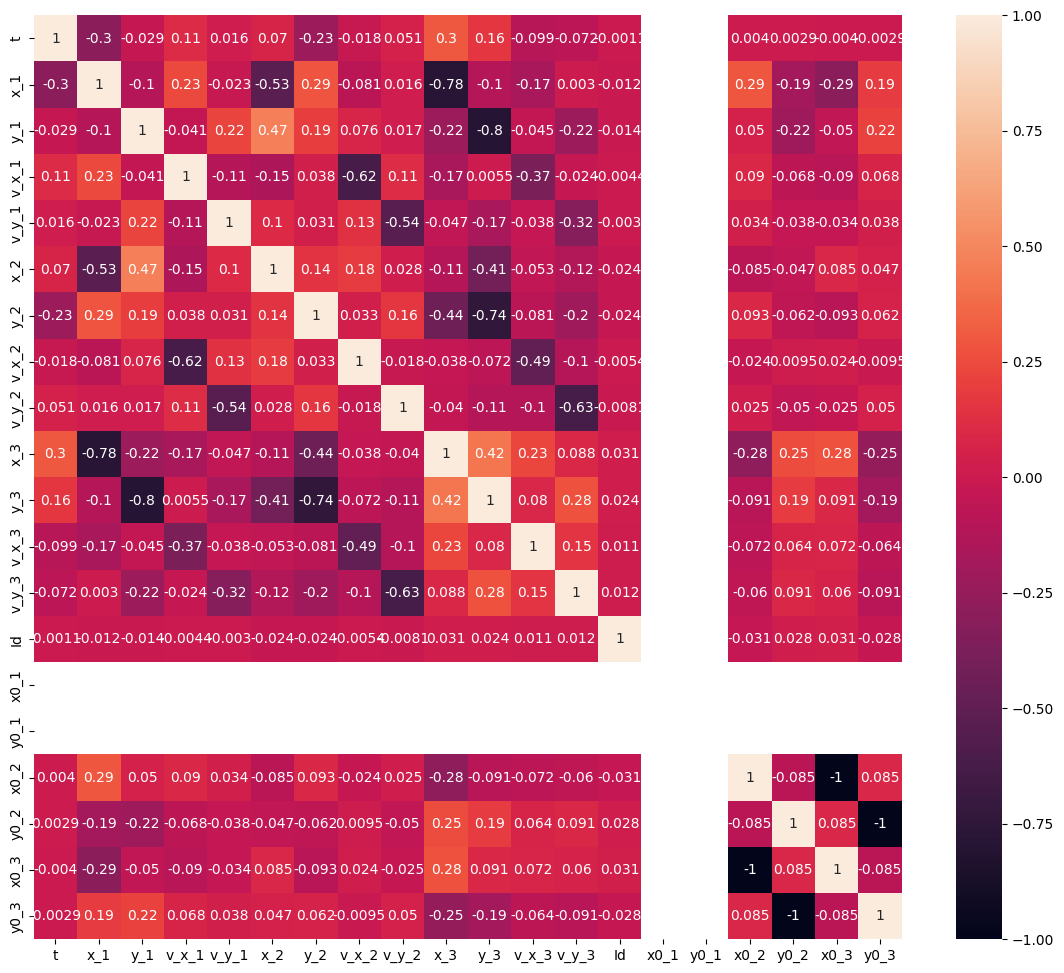

In [229]:
corr = updated_train_data.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr,annot=True)

corr_matrix = corr.abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Unstack, drop NaNs, and sort
sorted_corrs = upper_triangle.unstack().dropna().sort_values(ascending=False)

print(sorted_corrs.head(15))  # Top 15 strongest correlations

# Drop x0_1 and y0_1 because they are constant
# Drop y0_3 because it is highly correlated with y0_2
# Drop x0_3 because it is highly correlated with x0_2

x_train, y_train, updated_train_data = create_splits(train_data)
reduced_x_train = x_train.drop(columns=['x0_1','y0_1','x0_3','y0_3'])
reduced_y_train = y_train.copy()
reduced_pipeline = make_pipeline(StandardScaler(),LinearRegression())
reduced_pipeline.fit(reduced_x_train, reduced_y_train)

x_val, y_val,updated_val_data = create_splits(val_data)
reduced_x_val = x_val.drop(columns=['x0_1','y0_1','x0_3','y0_3'])
reduced_y_val = y_val.copy()
reduced_y_pred = reduced_pipeline.predict(reduced_x_val)

mse = mean_squared_error(reduced_y_val, reduced_y_pred)
print("MSE:",mse)
rmse = np.sqrt(mse)
print("RMSE:",rmse)